In [1]:
!pip install -q spacy
!pip install -q tensorflow
!pip install -q transformers

In [2]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam

# **Loading Data**

In [4]:
# Run only if you are using Google Colab
from google.colab import drive

'''drive.mount('/content/drive')

import os

path = '/content/drive/MyDrive/Colab Notebooks/Cap7''''

path = './datas'

Mounted at /content/drive


In [5]:
train_data = pd.read_csv(os.path.join(path, 'dados_treino.txt'), header = None, delimiter = ';')

test_data = pd.read_csv(os.path.join(path, 'dados_teste.txt'), header = None, delimiter = ';')

In [6]:
train_data = train_data.rename(columns = {0: 'text', 1: 'sentiment'})
test_data = test_data.rename(columns = {0: 'text', 1: 'sentiment'})

In [ ]:
train_data.shape

(16000, 2)

In [ ]:
test_data.shape

(2000, 2)

In [ ]:
train_data.head()

,text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [ ]:
train_data['sentiment'].value_counts()

sentiment
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [ ]:
test_data['sentiment'].value_counts()

sentiment
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

# **PreProcessing with Spacy**

In [7]:
# Download Dict
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
# Loading Dict
nlp_dict = spacy.load('en_core_web_md')

In [9]:
def preprocessing_text(text):
  # Processing text with Dict
  doc = nlp_dict(text)

  # Create an list with tokens
  tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

  # Return tokens
  return ' '.join(tokens)

In [10]:
train_data['Processed_text'] = train_data['text'].apply(preprocessing_text)

test_data['Processed_text'] = test_data['text'].apply(preprocessing_text)

In [ ]:
train_data.head()

,text,sentiment,Processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [11]:
lstm_tokenizer = Tokenizer()

lstm_tokenizer.fit_on_texts(train_data['Processed_text'])

In [12]:
word_index = lstm_tokenizer.word_index

In [ ]:
# Iterates over dictionary key-value pairs
for i, (chave, valor) in enumerate(word_index.items()):
    print(chave, valor)
    if i == 9:
        break

In [14]:
# Convert text to tokens sequences
train_seq = lstm_tokenizer.texts_to_sequences(train_data['Processed_text'])

In [15]:
# Max Length of Sequence
max_length = 100

In [16]:
train_seq_pad = pad_sequences(train_seq, maxlen = max_length, truncating = 'post')

In [17]:
test_seq = lstm_tokenizer.texts_to_sequences(test_data['Processed_text'])

test_seq_pad = pad_sequences(test_seq, maxlen = max_length, truncating = 'post')

In [18]:
# convert text to Number to train the model
label_encoder = LabelEncoder()

y_train_le = label_encoder.fit_transform(train_data['sentiment'])

y_test_le = label_encoder.transform(test_data['sentiment'])

y_train_encoded = to_categorical(y_train_le)
y_test_encoded = to_categorical(y_test_le)

# **Creating Model**

In [19]:
vocab_size = len(lstm_tokenizer.word_index) + 1

In [20]:
embedding_dim = max_length

In [21]:
model = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                            Bidirectional(LSTM(64)),
                            Dropout(0.4),
                            Dense(32, activation = 'leaky_relu', kernel_regularizer = 'l1_l2'),
                            Dense(6, activation = 'softmax')])

In [29]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', Precision(), Recall(), AUC()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189700   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1278506 (4.88 MB)
Trainable params: 1278506 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [31]:
input_data = np.array(train_seq_pad)
output_data = np.array(y_train_encoded)

In [32]:
num_epochs = 35
validation_split_value = 0.2
patience = 5

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = patience)

In [35]:
%%time
history = model.fit(input_data,
                    output_data,
                    epochs = num_epochs,
                    verbose = 1,
                    validation_split = validation_split_value,
                    callbacks = [early_stopping])

Epoch 1/35
400/400 [==============================] - 33s 56ms/step - loss: 2.3759 - accuracy: 0.3377 - precision_1: 0.5037 - recall: 0.0053 - auc: 0.7368 - val_loss: 1.3703 - val_accuracy: 0.4194 - val_precision_1: 0.5473 - val_recall: 0.1681 - val_auc: 0.8371
Epoch 2/35
400/400 [==============================] - 11s 26ms/step - loss: 1.2347 - accuracy: 0.4916 - precision_1: 0.6624 - recall: 0.2402 - auc: 0.8714 - val_loss: 1.0496 - val_accuracy: 0.6569 - val_precision_1: 0.8569 - val_recall: 0.5128 - val_auc: 0.9211
Epoch 3/35
400/400 [==============================] - 9s 22ms/step - loss: 0.8381 - accuracy: 0.7338 - precision_1: 0.9241 - recall: 0.5669 - auc: 0.9540 - val_loss: 0.7881 - val_accuracy: 0.7437 - val_precision_1: 0.9330 - val_recall: 0.5697 - val_auc: 0.9578
Epoch 4/35
400/400 [==============================] - 7s 17ms/step - loss: 0.6431 - accuracy: 0.8020 - precision_1: 0.9471 - recall: 0.6491 - auc: 0.9760 - val_loss: 0.7402 - val_accuracy: 0.7678 - val_precision_1: 

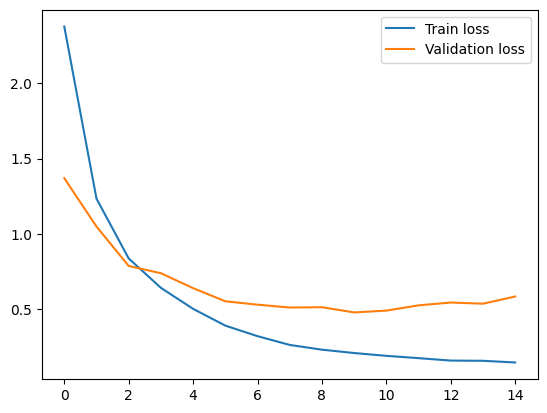

In [36]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend()
plt.show()

In [37]:
predict = model.predict(test_seq_pad)

63/63 [==============================] - 1s 6ms/step


In [38]:
predict_label = predict.argmax(axis = 1)

In [39]:
print(classification_report(y_test_le, predict_label))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       275
           1       0.86      0.84      0.85       224
           2       0.92      0.89      0.91       695
           3       0.68      0.79      0.73       159
           4       0.93      0.93      0.93       581
           5       0.63      0.71      0.67        66

    accuracy                           0.88      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.89      0.88      0.88      2000



In [40]:
print(confusion_matrix(y_test_le, predict_label))

[[242   8   5   1  16   3]
 [ 11 189   4   0   3  17]
 [  0   8 621  50  14   2]
 [  1   1  24 125   5   3]
 [ 10   8  14   4 542   3]
 [  1   7   6   3   2  47]]


In [41]:
print(accuracy_score(y_test_le, predict_label))

0.883


In [43]:
model.save('./models/model_v2.keras')

# **Deploy**

In [45]:
loaded_model = keras.models.load_model('./models/model_v2.keras')

In [46]:
phrase = 'i even feel a little shaky'

In [47]:
df = pd.DataFrame({'Phrase': [phrase]})

In [48]:
df['Processed_phrase'] = df['Phrase'].apply(preprocessing_text)

In [49]:
new_seq = lstm_tokenizer.texts_to_sequences(df['Processed_phrase'])
new_seq_pad = pad_sequences(new_seq, maxlen = max_length)

In [50]:
result = loaded_model.predict(new_seq_pad)

1/1 [==============================] - 1s 683ms/step


In [51]:
prob_result = np.argmax(result, axis = 1)

In [52]:
class_name = label_encoder.inverse_transform(prob_result)

In [53]:
class_name

array(['fear'], dtype=object)